# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [4]:
data_dir = './data'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper
import numpy as np

#helper.download_extract('mnist', data_dir)
#helper.download_extract('celeba', data_dir)
print("since network not stable, I download the data by tools")

since network not stable, I download the data by tools


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

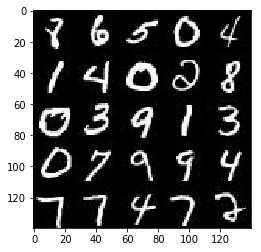

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

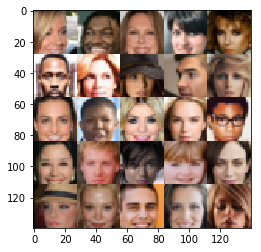

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/Gym/anaconda2/envs/dog-project/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="real_input_images")
    z_data = tf.placeholder(tf.float32, [None, z_dim], name="z_data") 
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    
    return real_input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    # TODO: Implement Function
    alpha = 0.2
        
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
                
        # 2 layer
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
                
        # 3 layer
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
              
        # flatten layer
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
                              
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
             
    with tf.variable_scope('generator', reuse=not is_train):

        # 1 layer
        # x1 = tf.layers.dense(z, 2*2*256) # starting with this number of units performs worse
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
   
        # 2 layer
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')   
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        # 3 layer    
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # dropout
        drop = tf.nn.dropout(x3, keep_prob=0.5)
               
        # output
        logits = tf.layers.conv2d_transpose(drop, out_channel_dim, 5, strides=1, padding='same')         
        out = tf.tanh(logits)
            
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.2
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
        
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [d_var for d_var in t_vars if d_var.name.startswith('discriminator')]
    g_vars = [g_var for g_var in t_vars if g_var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    d_updates = [d_update for d_update in update_ops if d_update.name.startswith('discriminator')]
    g_updates = [g_update for g_update in update_ops if g_update.name.startswith('generator')]

    with tf.control_dependencies(d_updates):
        d = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updates):
        g = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
            
    return d, g


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [22]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    print_every=10 
    show_every=100
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):

                steps += 1

                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2

                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)        


### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 18.6379... Generator Loss: 0.0010
Epoch 1/2... Discriminator Loss: 3.8967... Generator Loss: 0.0808
Epoch 1/2... Discriminator Loss: 1.0526... Generator Loss: 2.7326
Epoch 1/2... Discriminator Loss: 1.8723... Generator Loss: 0.5593
Epoch 1/2... Discriminator Loss: 1.9508... Generator Loss: 4.9697
Epoch 1/2... Discriminator Loss: 0.7535... Generator Loss: 1.9593
Epoch 1/2... Discriminator Loss: 1.6621... Generator Loss: 2.9041
Epoch 1/2... Discriminator Loss: 1.8353... Generator Loss: 3.3904
Epoch 1/2... Discriminator Loss: 1.8260... Generator Loss: 2.1231
Epoch 1/2... Discriminator Loss: 1.2882... Generator Loss: 1.0131


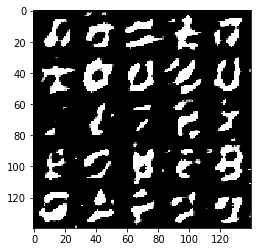

Epoch 1/2... Discriminator Loss: 1.7134... Generator Loss: 1.4536
Epoch 1/2... Discriminator Loss: 1.1956... Generator Loss: 1.1460
Epoch 1/2... Discriminator Loss: 1.4139... Generator Loss: 1.2129
Epoch 1/2... Discriminator Loss: 1.0166... Generator Loss: 1.8141
Epoch 1/2... Discriminator Loss: 1.2801... Generator Loss: 1.7247
Epoch 1/2... Discriminator Loss: 1.8427... Generator Loss: 2.3940
Epoch 1/2... Discriminator Loss: 2.6861... Generator Loss: 3.8712
Epoch 1/2... Discriminator Loss: 0.8302... Generator Loss: 1.7942
Epoch 1/2... Discriminator Loss: 1.1085... Generator Loss: 1.0092
Epoch 1/2... Discriminator Loss: 2.3171... Generator Loss: 0.4392


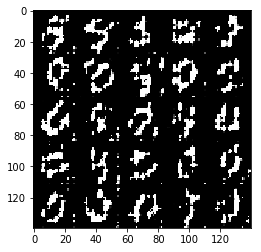

Epoch 1/2... Discriminator Loss: 1.2155... Generator Loss: 2.5084
Epoch 1/2... Discriminator Loss: 1.5036... Generator Loss: 0.5880
Epoch 1/2... Discriminator Loss: 1.0361... Generator Loss: 1.2063
Epoch 1/2... Discriminator Loss: 1.1515... Generator Loss: 1.7022
Epoch 1/2... Discriminator Loss: 1.4317... Generator Loss: 2.9266
Epoch 1/2... Discriminator Loss: 0.9556... Generator Loss: 1.9561
Epoch 1/2... Discriminator Loss: 1.2594... Generator Loss: 1.1738
Epoch 1/2... Discriminator Loss: 0.9437... Generator Loss: 1.1477
Epoch 1/2... Discriminator Loss: 1.2964... Generator Loss: 0.8217
Epoch 1/2... Discriminator Loss: 1.3348... Generator Loss: 0.7643


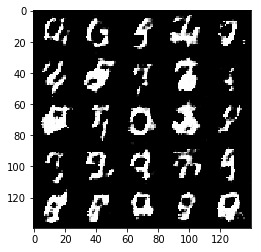

Epoch 1/2... Discriminator Loss: 0.9516... Generator Loss: 2.1420
Epoch 1/2... Discriminator Loss: 0.6359... Generator Loss: 3.1452
Epoch 1/2... Discriminator Loss: 0.6607... Generator Loss: 2.4886
Epoch 1/2... Discriminator Loss: 0.7460... Generator Loss: 1.8756
Epoch 1/2... Discriminator Loss: 1.3203... Generator Loss: 0.8048
Epoch 1/2... Discriminator Loss: 1.1390... Generator Loss: 1.1312
Epoch 1/2... Discriminator Loss: 0.8825... Generator Loss: 1.7670
Epoch 1/2... Discriminator Loss: 0.7974... Generator Loss: 2.2030
Epoch 1/2... Discriminator Loss: 0.7177... Generator Loss: 2.7200
Epoch 1/2... Discriminator Loss: 0.9472... Generator Loss: 1.3024


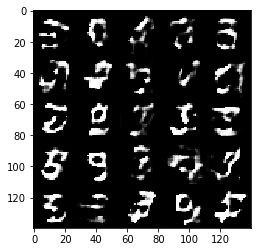

Epoch 1/2... Discriminator Loss: 0.8194... Generator Loss: 1.7839
Epoch 1/2... Discriminator Loss: 3.3254... Generator Loss: 0.1842
Epoch 1/2... Discriminator Loss: 1.2736... Generator Loss: 0.9753
Epoch 1/2... Discriminator Loss: 1.2079... Generator Loss: 1.5841
Epoch 1/2... Discriminator Loss: 1.1630... Generator Loss: 1.6403
Epoch 1/2... Discriminator Loss: 1.1828... Generator Loss: 1.2118
Epoch 1/2... Discriminator Loss: 1.1753... Generator Loss: 0.9313
Epoch 1/2... Discriminator Loss: 1.6161... Generator Loss: 2.5532
Epoch 1/2... Discriminator Loss: 1.4012... Generator Loss: 0.6320
Epoch 1/2... Discriminator Loss: 1.0760... Generator Loss: 1.3384


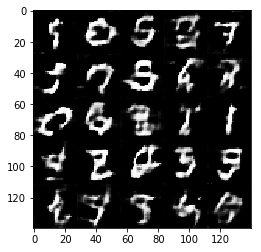

Epoch 1/2... Discriminator Loss: 1.3403... Generator Loss: 2.2536
Epoch 1/2... Discriminator Loss: 1.1463... Generator Loss: 1.0233
Epoch 1/2... Discriminator Loss: 1.2434... Generator Loss: 0.9162
Epoch 1/2... Discriminator Loss: 1.0827... Generator Loss: 1.7074
Epoch 1/2... Discriminator Loss: 1.3905... Generator Loss: 1.8611
Epoch 1/2... Discriminator Loss: 1.2270... Generator Loss: 1.2717
Epoch 1/2... Discriminator Loss: 1.1080... Generator Loss: 1.4438
Epoch 1/2... Discriminator Loss: 1.2971... Generator Loss: 0.8505
Epoch 1/2... Discriminator Loss: 1.0761... Generator Loss: 1.0717
Epoch 1/2... Discriminator Loss: 1.1035... Generator Loss: 1.3783


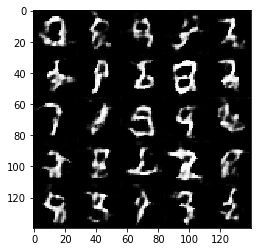

Epoch 1/2... Discriminator Loss: 1.0976... Generator Loss: 1.5629
Epoch 1/2... Discriminator Loss: 1.0083... Generator Loss: 1.2436
Epoch 1/2... Discriminator Loss: 1.1916... Generator Loss: 0.9186
Epoch 1/2... Discriminator Loss: 1.2518... Generator Loss: 0.7564
Epoch 1/2... Discriminator Loss: 1.1859... Generator Loss: 0.8264
Epoch 1/2... Discriminator Loss: 1.0653... Generator Loss: 1.2629
Epoch 1/2... Discriminator Loss: 1.5072... Generator Loss: 2.3152
Epoch 1/2... Discriminator Loss: 1.1035... Generator Loss: 1.8457
Epoch 1/2... Discriminator Loss: 1.1648... Generator Loss: 1.2604
Epoch 1/2... Discriminator Loss: 1.3324... Generator Loss: 0.7155


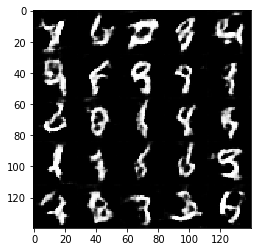

Epoch 1/2... Discriminator Loss: 1.3888... Generator Loss: 0.6704
Epoch 1/2... Discriminator Loss: 1.9215... Generator Loss: 3.0149
Epoch 1/2... Discriminator Loss: 1.1695... Generator Loss: 0.8609
Epoch 1/2... Discriminator Loss: 1.0399... Generator Loss: 1.1151
Epoch 1/2... Discriminator Loss: 1.0827... Generator Loss: 1.2249
Epoch 1/2... Discriminator Loss: 1.2027... Generator Loss: 0.9417
Epoch 1/2... Discriminator Loss: 1.4873... Generator Loss: 0.6642
Epoch 1/2... Discriminator Loss: 1.1083... Generator Loss: 1.0204
Epoch 1/2... Discriminator Loss: 1.3731... Generator Loss: 0.7047
Epoch 1/2... Discriminator Loss: 1.1146... Generator Loss: 1.0332


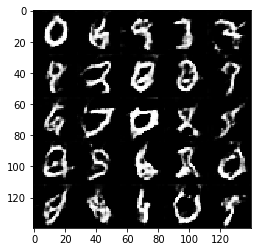

Epoch 1/2... Discriminator Loss: 1.2791... Generator Loss: 0.8884
Epoch 1/2... Discriminator Loss: 1.5314... Generator Loss: 0.5601
Epoch 1/2... Discriminator Loss: 1.0528... Generator Loss: 1.3414
Epoch 1/2... Discriminator Loss: 1.6666... Generator Loss: 0.4709
Epoch 1/2... Discriminator Loss: 1.1226... Generator Loss: 1.5535
Epoch 1/2... Discriminator Loss: 1.3422... Generator Loss: 1.5321
Epoch 1/2... Discriminator Loss: 1.0712... Generator Loss: 1.0237
Epoch 1/2... Discriminator Loss: 1.7379... Generator Loss: 0.4293
Epoch 1/2... Discriminator Loss: 1.1690... Generator Loss: 0.8675
Epoch 1/2... Discriminator Loss: 1.7875... Generator Loss: 0.4677


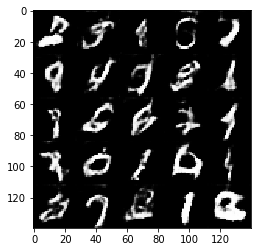

Epoch 1/2... Discriminator Loss: 1.1258... Generator Loss: 2.2505
Epoch 1/2... Discriminator Loss: 0.9511... Generator Loss: 1.3405
Epoch 1/2... Discriminator Loss: 1.9212... Generator Loss: 3.2889
Epoch 2/2... Discriminator Loss: 1.1981... Generator Loss: 0.7740
Epoch 2/2... Discriminator Loss: 1.3136... Generator Loss: 0.7057
Epoch 2/2... Discriminator Loss: 1.1853... Generator Loss: 0.9121
Epoch 2/2... Discriminator Loss: 1.6652... Generator Loss: 0.5155
Epoch 2/2... Discriminator Loss: 1.6007... Generator Loss: 0.4886
Epoch 2/2... Discriminator Loss: 1.3999... Generator Loss: 0.6510
Epoch 2/2... Discriminator Loss: 1.1271... Generator Loss: 1.1070


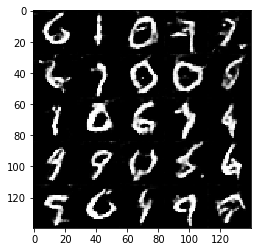

Epoch 2/2... Discriminator Loss: 1.0527... Generator Loss: 1.1732
Epoch 2/2... Discriminator Loss: 1.0419... Generator Loss: 1.0598
Epoch 2/2... Discriminator Loss: 1.7058... Generator Loss: 0.4321
Epoch 2/2... Discriminator Loss: 1.2683... Generator Loss: 1.7528
Epoch 2/2... Discriminator Loss: 1.2176... Generator Loss: 0.8838
Epoch 2/2... Discriminator Loss: 1.1141... Generator Loss: 1.3008
Epoch 2/2... Discriminator Loss: 1.2308... Generator Loss: 0.9858
Epoch 2/2... Discriminator Loss: 1.4723... Generator Loss: 2.1236
Epoch 2/2... Discriminator Loss: 1.0691... Generator Loss: 1.2826
Epoch 2/2... Discriminator Loss: 1.3501... Generator Loss: 0.6565


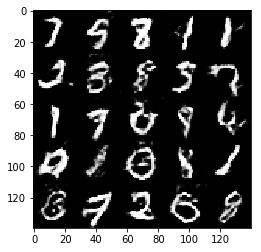

Epoch 2/2... Discriminator Loss: 1.5798... Generator Loss: 0.6229
Epoch 2/2... Discriminator Loss: 1.4775... Generator Loss: 2.6280
Epoch 2/2... Discriminator Loss: 1.3864... Generator Loss: 2.2256
Epoch 2/2... Discriminator Loss: 1.5153... Generator Loss: 0.4998
Epoch 2/2... Discriminator Loss: 1.1113... Generator Loss: 0.9742
Epoch 2/2... Discriminator Loss: 1.2150... Generator Loss: 0.9829
Epoch 2/2... Discriminator Loss: 1.4913... Generator Loss: 0.6039
Epoch 2/2... Discriminator Loss: 0.9233... Generator Loss: 1.5691
Epoch 2/2... Discriminator Loss: 1.0885... Generator Loss: 1.0651
Epoch 2/2... Discriminator Loss: 1.2763... Generator Loss: 2.1909


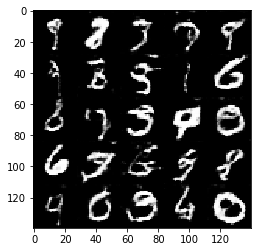

Epoch 2/2... Discriminator Loss: 1.0796... Generator Loss: 1.1584
Epoch 2/2... Discriminator Loss: 1.2523... Generator Loss: 1.8001
Epoch 2/2... Discriminator Loss: 0.9037... Generator Loss: 1.5701
Epoch 2/2... Discriminator Loss: 1.2162... Generator Loss: 0.8560
Epoch 2/2... Discriminator Loss: 1.0828... Generator Loss: 1.7688
Epoch 2/2... Discriminator Loss: 1.1764... Generator Loss: 0.8891
Epoch 2/2... Discriminator Loss: 1.0715... Generator Loss: 1.0840
Epoch 2/2... Discriminator Loss: 1.4077... Generator Loss: 0.7457
Epoch 2/2... Discriminator Loss: 1.0982... Generator Loss: 1.0352
Epoch 2/2... Discriminator Loss: 1.0171... Generator Loss: 1.6516


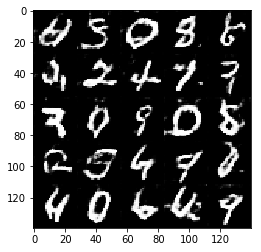

Epoch 2/2... Discriminator Loss: 1.7055... Generator Loss: 0.4737
Epoch 2/2... Discriminator Loss: 1.2048... Generator Loss: 2.5029
Epoch 2/2... Discriminator Loss: 0.8635... Generator Loss: 1.6811
Epoch 2/2... Discriminator Loss: 2.5090... Generator Loss: 3.6057
Epoch 2/2... Discriminator Loss: 1.0773... Generator Loss: 1.2408
Epoch 2/2... Discriminator Loss: 1.1813... Generator Loss: 0.8578
Epoch 2/2... Discriminator Loss: 0.9023... Generator Loss: 1.5011
Epoch 2/2... Discriminator Loss: 1.0224... Generator Loss: 1.2235
Epoch 2/2... Discriminator Loss: 1.1937... Generator Loss: 0.8537
Epoch 2/2... Discriminator Loss: 1.0544... Generator Loss: 1.0736


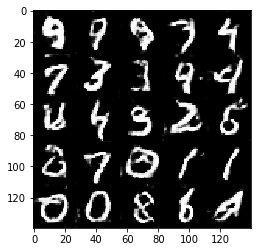

Epoch 2/2... Discriminator Loss: 0.9467... Generator Loss: 1.4309
Epoch 2/2... Discriminator Loss: 0.9416... Generator Loss: 1.8272
Epoch 2/2... Discriminator Loss: 1.0290... Generator Loss: 1.0471
Epoch 2/2... Discriminator Loss: 0.9555... Generator Loss: 1.7709
Epoch 2/2... Discriminator Loss: 0.9328... Generator Loss: 1.5019
Epoch 2/2... Discriminator Loss: 1.0839... Generator Loss: 1.0666
Epoch 2/2... Discriminator Loss: 1.2019... Generator Loss: 2.1481
Epoch 2/2... Discriminator Loss: 0.9895... Generator Loss: 1.2875
Epoch 2/2... Discriminator Loss: 1.5180... Generator Loss: 0.5620
Epoch 2/2... Discriminator Loss: 1.1645... Generator Loss: 2.3868


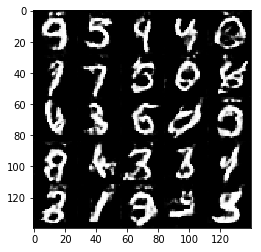

Epoch 2/2... Discriminator Loss: 0.8448... Generator Loss: 1.7258
Epoch 2/2... Discriminator Loss: 0.9057... Generator Loss: 2.6012
Epoch 2/2... Discriminator Loss: 1.9791... Generator Loss: 0.4042
Epoch 2/2... Discriminator Loss: 0.9023... Generator Loss: 1.2954
Epoch 2/2... Discriminator Loss: 1.0864... Generator Loss: 1.1564
Epoch 2/2... Discriminator Loss: 0.7064... Generator Loss: 1.9712
Epoch 2/2... Discriminator Loss: 1.0685... Generator Loss: 2.8868
Epoch 2/2... Discriminator Loss: 0.9352... Generator Loss: 1.5153
Epoch 2/2... Discriminator Loss: 0.8156... Generator Loss: 1.6753
Epoch 2/2... Discriminator Loss: 1.0772... Generator Loss: 1.8552


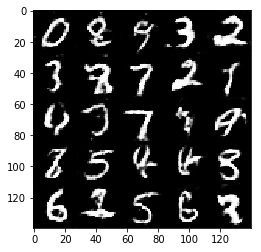

Epoch 2/2... Discriminator Loss: 0.8686... Generator Loss: 1.5428
Epoch 2/2... Discriminator Loss: 1.0221... Generator Loss: 1.1206
Epoch 2/2... Discriminator Loss: 0.8927... Generator Loss: 1.7072
Epoch 2/2... Discriminator Loss: 0.9567... Generator Loss: 1.2592
Epoch 2/2... Discriminator Loss: 0.9048... Generator Loss: 1.8740
Epoch 2/2... Discriminator Loss: 0.7969... Generator Loss: 1.7556
Epoch 2/2... Discriminator Loss: 1.1818... Generator Loss: 0.9336
Epoch 2/2... Discriminator Loss: 0.9196... Generator Loss: 1.5193
Epoch 2/2... Discriminator Loss: 1.8036... Generator Loss: 0.5005
Epoch 2/2... Discriminator Loss: 1.5015... Generator Loss: 0.5888


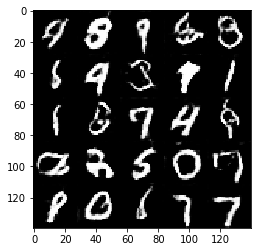

Epoch 2/2... Discriminator Loss: 0.8826... Generator Loss: 1.4743
Epoch 2/2... Discriminator Loss: 0.8479... Generator Loss: 1.8910
Epoch 2/2... Discriminator Loss: 1.0699... Generator Loss: 0.9389
Epoch 2/2... Discriminator Loss: 1.5694... Generator Loss: 0.5390
Epoch 2/2... Discriminator Loss: 1.1027... Generator Loss: 1.1001
Epoch 2/2... Discriminator Loss: 1.4401... Generator Loss: 0.6629
Epoch 2/2... Discriminator Loss: 1.2663... Generator Loss: 0.8640
Epoch 2/2... Discriminator Loss: 1.2640... Generator Loss: 1.0170
Epoch 2/2... Discriminator Loss: 1.0091... Generator Loss: 1.4768
Epoch 2/2... Discriminator Loss: 0.9592... Generator Loss: 1.2621


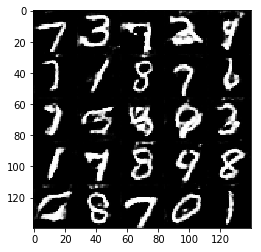

Epoch 2/2... Discriminator Loss: 0.8778... Generator Loss: 1.9094
Epoch 2/2... Discriminator Loss: 0.7623... Generator Loss: 2.0271
Epoch 2/2... Discriminator Loss: 1.0564... Generator Loss: 1.4020
Epoch 2/2... Discriminator Loss: 1.6180... Generator Loss: 2.8577
Epoch 2/2... Discriminator Loss: 0.8963... Generator Loss: 2.0921
Epoch 2/2... Discriminator Loss: 1.6279... Generator Loss: 0.6065
Epoch 2/2... Discriminator Loss: 1.3654... Generator Loss: 0.6838


In [24]:
batch_size = 64
z_dim = 100
learning_rate = 0.01
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 2.1672... Generator Loss: 10.3074
Epoch 1/1... Discriminator Loss: 6.9934... Generator Loss: 8.0023
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 2.7420
Epoch 1/1... Discriminator Loss: 1.6738... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.6147... Generator Loss: 2.5341
Epoch 1/1... Discriminator Loss: 1.9475... Generator Loss: 0.5497
Epoch 1/1... Discriminator Loss: 0.8627... Generator Loss: 1.8312
Epoch 1/1... Discriminator Loss: 0.7276... Generator Loss: 2.3494
Epoch 1/1... Discriminator Loss: 0.7275... Generator Loss: 3.1245
Epoch 1/1... Discriminator Loss: 0.6348... Generator Loss: 2.5962


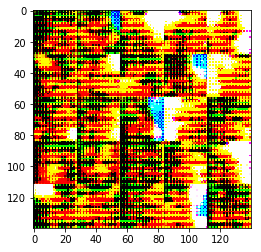

Epoch 1/1... Discriminator Loss: 0.6002... Generator Loss: 3.0433
Epoch 1/1... Discriminator Loss: 0.8337... Generator Loss: 1.7638
Epoch 1/1... Discriminator Loss: 0.7219... Generator Loss: 2.0846
Epoch 1/1... Discriminator Loss: 2.3414... Generator Loss: 2.4971
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 1.2556
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 1.0619
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 2.3751
Epoch 1/1... Discriminator Loss: 0.9333... Generator Loss: 1.8079
Epoch 1/1... Discriminator Loss: 1.0230... Generator Loss: 1.4604
Epoch 1/1... Discriminator Loss: 0.8945... Generator Loss: 1.4100


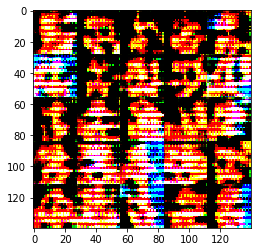

Epoch 1/1... Discriminator Loss: 0.7733... Generator Loss: 1.5825
Epoch 1/1... Discriminator Loss: 0.8685... Generator Loss: 1.6892
Epoch 1/1... Discriminator Loss: 0.8411... Generator Loss: 1.8884
Epoch 1/1... Discriminator Loss: 0.6583... Generator Loss: 2.3384
Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 1.6314
Epoch 1/1... Discriminator Loss: 0.9176... Generator Loss: 1.4410
Epoch 1/1... Discriminator Loss: 0.7318... Generator Loss: 2.8542
Epoch 1/1... Discriminator Loss: 0.7358... Generator Loss: 1.7387
Epoch 1/1... Discriminator Loss: 0.6016... Generator Loss: 3.2342
Epoch 1/1... Discriminator Loss: 0.6157... Generator Loss: 3.4550


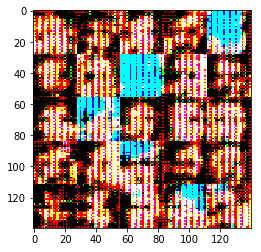

Epoch 1/1... Discriminator Loss: 0.5717... Generator Loss: 3.8815
Epoch 1/1... Discriminator Loss: 0.5315... Generator Loss: 4.3494
Epoch 1/1... Discriminator Loss: 0.5456... Generator Loss: 3.4850
Epoch 1/1... Discriminator Loss: 1.5207... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 0.5808... Generator Loss: 3.8729
Epoch 1/1... Discriminator Loss: 0.5281... Generator Loss: 5.0576
Epoch 1/1... Discriminator Loss: 0.5270... Generator Loss: 4.4825
Epoch 1/1... Discriminator Loss: 0.5066... Generator Loss: 6.6138
Epoch 1/1... Discriminator Loss: 0.5334... Generator Loss: 3.8988
Epoch 1/1... Discriminator Loss: 0.5149... Generator Loss: 4.8835


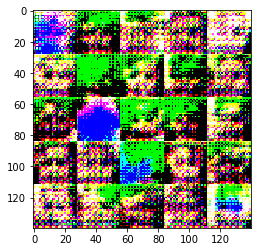

Epoch 1/1... Discriminator Loss: 0.5082... Generator Loss: 5.5078
Epoch 1/1... Discriminator Loss: 0.5299... Generator Loss: 4.7666
Epoch 1/1... Discriminator Loss: 0.5158... Generator Loss: 5.1510
Epoch 1/1... Discriminator Loss: 0.5127... Generator Loss: 5.9292
Epoch 1/1... Discriminator Loss: 0.5126... Generator Loss: 5.8898
Epoch 1/1... Discriminator Loss: 0.5118... Generator Loss: 5.9456
Epoch 1/1... Discriminator Loss: 0.5063... Generator Loss: 5.8180
Epoch 1/1... Discriminator Loss: 0.5067... Generator Loss: 7.3899
Epoch 1/1... Discriminator Loss: 0.5081... Generator Loss: 5.7146
Epoch 1/1... Discriminator Loss: 0.5068... Generator Loss: 5.8061


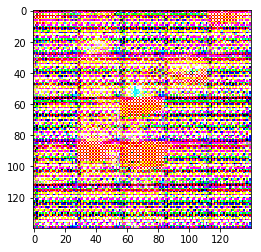

Epoch 1/1... Discriminator Loss: 0.5075... Generator Loss: 5.9388
Epoch 1/1... Discriminator Loss: 0.5053... Generator Loss: 5.8561
Epoch 1/1... Discriminator Loss: 0.5034... Generator Loss: 8.7478
Epoch 1/1... Discriminator Loss: 0.5043... Generator Loss: 8.4114
Epoch 1/1... Discriminator Loss: 0.5042... Generator Loss: 6.9467
Epoch 1/1... Discriminator Loss: 0.5020... Generator Loss: 7.3763
Epoch 1/1... Discriminator Loss: 0.5046... Generator Loss: 5.7557
Epoch 1/1... Discriminator Loss: 0.5057... Generator Loss: 5.7816
Epoch 1/1... Discriminator Loss: 0.5097... Generator Loss: 12.6800
Epoch 1/1... Discriminator Loss: 0.5019... Generator Loss: 12.7784


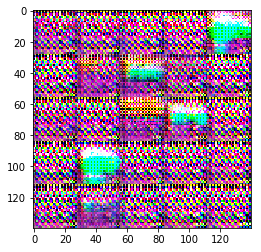

Epoch 1/1... Discriminator Loss: 0.5041... Generator Loss: 11.8483
Epoch 1/1... Discriminator Loss: 0.5092... Generator Loss: 7.7868
Epoch 1/1... Discriminator Loss: 0.5019... Generator Loss: 11.8314
Epoch 1/1... Discriminator Loss: 0.5032... Generator Loss: 7.3694
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 1.7946
Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 1.5119
Epoch 1/1... Discriminator Loss: 1.8718... Generator Loss: 2.0778
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 1.7528
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 1.2913


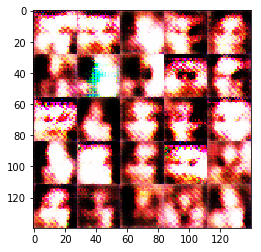

Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 1.0034
Epoch 1/1... Discriminator Loss: 1.1834... Generator Loss: 1.0662
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 0.9246
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 1.2462
Epoch 1/1... Discriminator Loss: 1.8225... Generator Loss: 3.0087
Epoch 1/1... Discriminator Loss: 0.8042... Generator Loss: 1.6400
Epoch 1/1... Discriminator Loss: 0.7058... Generator Loss: 2.3793
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.9586
Epoch 1/1... Discriminator Loss: 1.2018... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 0.7992... Generator Loss: 1.6794


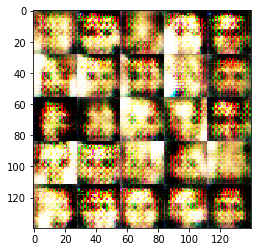

Epoch 1/1... Discriminator Loss: 0.6757... Generator Loss: 4.6729
Epoch 1/1... Discriminator Loss: 1.8249... Generator Loss: 0.4480
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 1.1333
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 1.1388
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 1.0352
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 2.5870
Epoch 1/1... Discriminator Loss: 1.0536... Generator Loss: 1.0725
Epoch 1/1... Discriminator Loss: 1.6595... Generator Loss: 0.5301
Epoch 1/1... Discriminator Loss: 0.7557... Generator Loss: 2.6163
Epoch 1/1... Discriminator Loss: 0.5861... Generator Loss: 2.9280


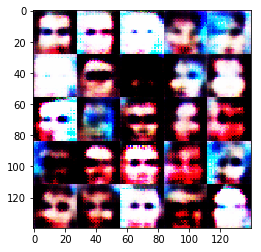

Epoch 1/1... Discriminator Loss: 1.0331... Generator Loss: 0.9948
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.6846... Generator Loss: 0.4068
Epoch 1/1... Discriminator Loss: 0.7423... Generator Loss: 3.5936
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 0.6588... Generator Loss: 2.3203
Epoch 1/1... Discriminator Loss: 0.6287... Generator Loss: 3.0508
Epoch 1/1... Discriminator Loss: 1.7896... Generator Loss: 8.9574
Epoch 1/1... Discriminator Loss: 0.5301... Generator Loss: 6.7766
Epoch 1/1... Discriminator Loss: 0.5988... Generator Loss: 2.6378


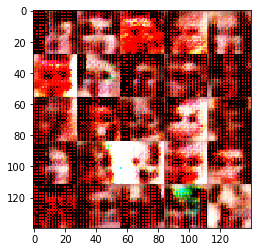

Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 0.7232... Generator Loss: 6.6678
Epoch 1/1... Discriminator Loss: 0.5258... Generator Loss: 4.3666
Epoch 1/1... Discriminator Loss: 0.5116... Generator Loss: 5.4937
Epoch 1/1... Discriminator Loss: 0.5205... Generator Loss: 4.4635
Epoch 1/1... Discriminator Loss: 0.5207... Generator Loss: 4.3949
Epoch 1/1... Discriminator Loss: 0.5097... Generator Loss: 5.4814
Epoch 1/1... Discriminator Loss: 0.5264... Generator Loss: 10.0008
Epoch 1/1... Discriminator Loss: 0.5121... Generator Loss: 5.3772
Epoch 1/1... Discriminator Loss: 0.5084... Generator Loss: 14.8122


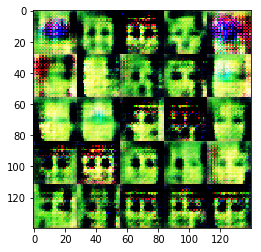

Epoch 1/1... Discriminator Loss: 0.5709... Generator Loss: 4.1807
Epoch 1/1... Discriminator Loss: 0.5416... Generator Loss: 3.5780
Epoch 1/1... Discriminator Loss: 0.5119... Generator Loss: 5.8644
Epoch 1/1... Discriminator Loss: 0.5239... Generator Loss: 5.2863
Epoch 1/1... Discriminator Loss: 0.5201... Generator Loss: 14.7109
Epoch 1/1... Discriminator Loss: 0.5217... Generator Loss: 4.1982
Epoch 1/1... Discriminator Loss: 0.5060... Generator Loss: 8.7284
Epoch 1/1... Discriminator Loss: 0.5363... Generator Loss: 3.6114
Epoch 1/1... Discriminator Loss: 0.5140... Generator Loss: 4.7060
Epoch 1/1... Discriminator Loss: 1.5789... Generator Loss: 4.0290


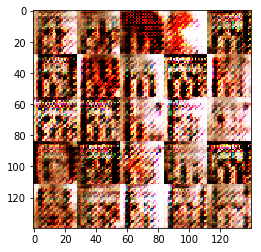

Epoch 1/1... Discriminator Loss: 1.0591... Generator Loss: 1.4327
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 2.3576
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 13.7515
Epoch 1/1... Discriminator Loss: 0.5316... Generator Loss: 4.0967
Epoch 1/1... Discriminator Loss: 0.5879... Generator Loss: 12.0785
Epoch 1/1... Discriminator Loss: 0.5250... Generator Loss: 4.2846
Epoch 1/1... Discriminator Loss: 0.6954... Generator Loss: 2.0583
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 1.0943


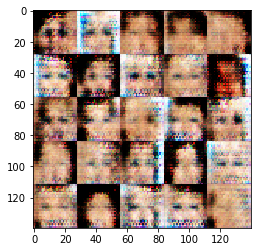

Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 1.1609
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.1697... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.9170
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 1.1853
Epoch 1/1... Discriminator Loss: 0.9028... Generator Loss: 5.0132
Epoch 1/1... Discriminator Loss: 1.1166... Generator Loss: 4.4658
Epoch 1/1... Discriminator Loss: 0.5225... Generator Loss: 7.1110
Epoch 1/1... Discriminator Loss: 0.9567... Generator Loss: 1.0886


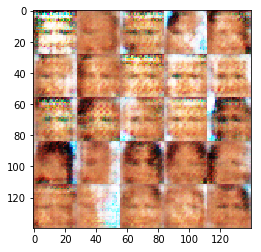

Epoch 1/1... Discriminator Loss: 0.6082... Generator Loss: 2.4824
Epoch 1/1... Discriminator Loss: 0.5319... Generator Loss: 4.3868
Epoch 1/1... Discriminator Loss: 0.5152... Generator Loss: 16.1262
Epoch 1/1... Discriminator Loss: 0.5084... Generator Loss: 6.0940
Epoch 1/1... Discriminator Loss: 0.5091... Generator Loss: 6.3914
Epoch 1/1... Discriminator Loss: 0.5056... Generator Loss: 7.0107
Epoch 1/1... Discriminator Loss: 0.5057... Generator Loss: 7.0182
Epoch 1/1... Discriminator Loss: 0.5060... Generator Loss: 7.0336
Epoch 1/1... Discriminator Loss: 0.5064... Generator Loss: 6.2572
Epoch 1/1... Discriminator Loss: 0.5058... Generator Loss: 6.7376


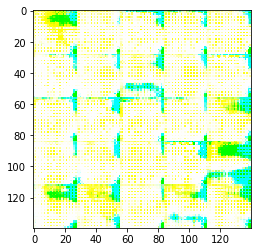

Epoch 1/1... Discriminator Loss: 0.5042... Generator Loss: 6.9349
Epoch 1/1... Discriminator Loss: 0.5050... Generator Loss: 7.0932
Epoch 1/1... Discriminator Loss: 0.5038... Generator Loss: 7.2776
Epoch 1/1... Discriminator Loss: 0.5064... Generator Loss: 7.0757
Epoch 1/1... Discriminator Loss: 0.5029... Generator Loss: 7.3305
Epoch 1/1... Discriminator Loss: 0.5044... Generator Loss: 7.1875
Epoch 1/1... Discriminator Loss: 0.5027... Generator Loss: 7.4999
Epoch 1/1... Discriminator Loss: 0.5026... Generator Loss: 7.2889
Epoch 1/1... Discriminator Loss: 0.5036... Generator Loss: 7.5119
Epoch 1/1... Discriminator Loss: 0.5032... Generator Loss: 7.7670


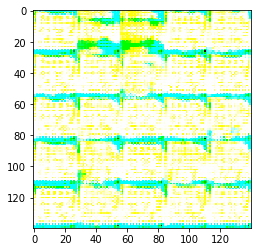

Epoch 1/1... Discriminator Loss: 0.5023... Generator Loss: 7.7470
Epoch 1/1... Discriminator Loss: 0.5023... Generator Loss: 7.9646
Epoch 1/1... Discriminator Loss: 0.5032... Generator Loss: 8.1065
Epoch 1/1... Discriminator Loss: 0.5024... Generator Loss: 8.0577
Epoch 1/1... Discriminator Loss: 0.5030... Generator Loss: 7.9392
Epoch 1/1... Discriminator Loss: 0.5022... Generator Loss: 7.9147
Epoch 1/1... Discriminator Loss: 0.5020... Generator Loss: 8.1723
Epoch 1/1... Discriminator Loss: 0.5018... Generator Loss: 8.1340
Epoch 1/1... Discriminator Loss: 0.5022... Generator Loss: 7.6584
Epoch 1/1... Discriminator Loss: 0.5031... Generator Loss: 6.8679


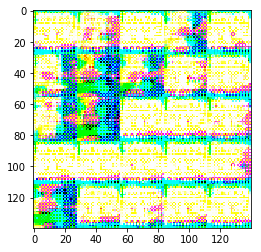

Epoch 1/1... Discriminator Loss: 0.5068... Generator Loss: 5.4776
Epoch 1/1... Discriminator Loss: 0.5168... Generator Loss: 4.3059
Epoch 1/1... Discriminator Loss: 0.5056... Generator Loss: 6.2126
Epoch 1/1... Discriminator Loss: 0.5088... Generator Loss: 5.3152
Epoch 1/1... Discriminator Loss: 0.5035... Generator Loss: 8.6978
Epoch 1/1... Discriminator Loss: 0.5028... Generator Loss: 12.0860
Epoch 1/1... Discriminator Loss: 0.5115... Generator Loss: 5.0577
Epoch 1/1... Discriminator Loss: 0.5093... Generator Loss: 6.0162
Epoch 1/1... Discriminator Loss: 0.5099... Generator Loss: 5.0657
Epoch 1/1... Discriminator Loss: 0.5028... Generator Loss: 7.5976


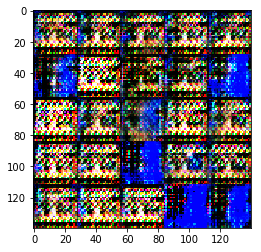

Epoch 1/1... Discriminator Loss: 0.5046... Generator Loss: 10.5186
Epoch 1/1... Discriminator Loss: 0.5090... Generator Loss: 5.5508
Epoch 1/1... Discriminator Loss: 0.5101... Generator Loss: 11.2652
Epoch 1/1... Discriminator Loss: 0.7734... Generator Loss: 1.6933
Epoch 1/1... Discriminator Loss: 1.0395... Generator Loss: 1.0594
Epoch 1/1... Discriminator Loss: 2.5359... Generator Loss: 4.0294
Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 1.4150
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 1.1420
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.6136
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.8323


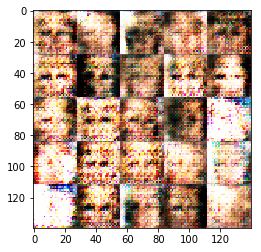

Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.6224
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.2218... Generator Loss: 0.9830
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.9335
Epoch 1/1... Discriminator Loss: 1.6089... Generator Loss: 2.1069
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 1.1025
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 1.6997
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 0.9247
Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 1.0597
Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 1.6906


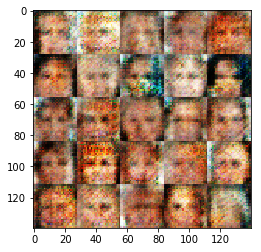

Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.6224
Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 0.9208
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 0.9586
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 0.9355
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 1.0003
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 1.1118
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 0.9369
Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 1.1956
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 1.1418
Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 1.0458


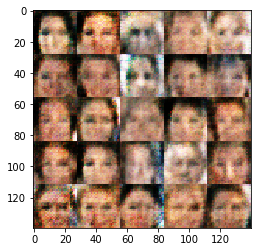

Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.8720
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 1.7291
Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 1.5108
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 0.8844
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 1.0865
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 1.5133... Generator Loss: 1.8922
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 1.6228


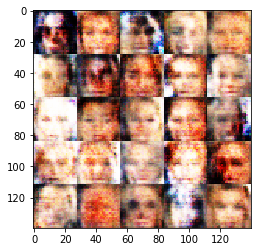

Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 1.2502
Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 1.2339
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 1.2440
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.1945... Generator Loss: 1.2035
Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.5509
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 1.2674
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 1.0135
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.9255


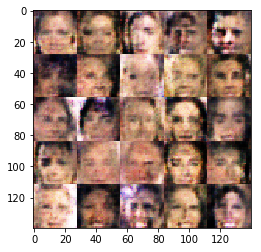

Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 0.9310
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 1.5275
Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 1.0620
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 1.1713
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.8928
Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 1.1124
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 1.0945
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.7652


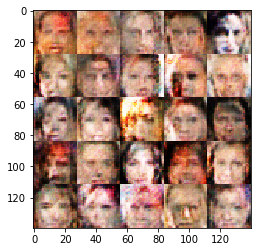

Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 0.9727
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 0.8292
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 1.0684
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.9038
Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 1.1487
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 1.0090


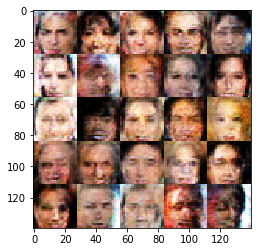

Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 1.2094
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 1.0026
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 1.3269
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 1.0489
Epoch 1/1... Discriminator Loss: 1.2334... Generator Loss: 1.1659
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 0.9161
Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 1.0598
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 1.0272


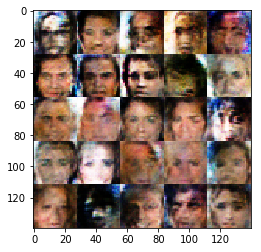

Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 1.7369
Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 1.0562
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 1.3481
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.5785
Epoch 1/1... Discriminator Loss: 1.2459... Generator Loss: 1.3696
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 1.0176
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 1.3374
Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 1.2699
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.7757


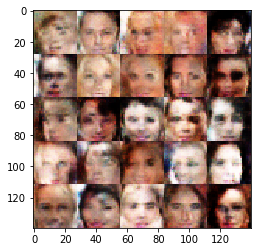

Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 1.4015
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 1.2080
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 1.0810
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 1.3111
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 1.1094
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 1.2375
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 1.6423


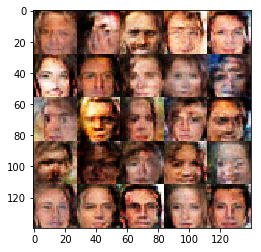

Epoch 1/1... Discriminator Loss: 1.1291... Generator Loss: 1.1609
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 1.3383
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 1.2556
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 1.1604
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 1.2731
Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 0.8913
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 1.0216
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 1.6523


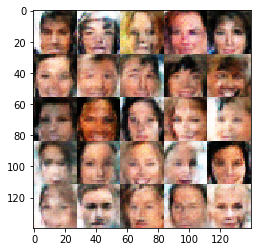

Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.6012
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 0.9143
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 0.9389
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 1.1869
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 1.0938
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.7325


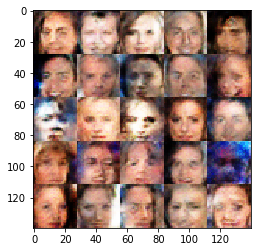

Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 0.9384
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 0.9330
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.6499
Epoch 1/1... Discriminator Loss: 1.1784... Generator Loss: 1.0249
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 1.3717
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 1.0949


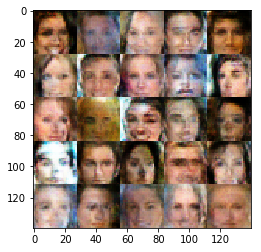

Epoch 1/1... Discriminator Loss: 1.1907... Generator Loss: 0.9261
Epoch 1/1... Discriminator Loss: 1.1768... Generator Loss: 0.8703
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 1.8985
Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 0.9556
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 0.9301


In [25]:
batch_size = 64
z_dim = 100
learning_rate = 0.01
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。